# Testing the pulser and acquisition from the RPi


## Idea behind it


Proof of concept is being explored

Servo control:
> http://www.toptechboy.com/raspberry-pi/raspberry-pi-lesson-28-controlling-a-servo-on-raspberry-pi-with-python/
    
    
    
## Initiating

In [1]:
FilePath = "20170507.npz"
import matplotlib.pyplot as plt
import numpy as np
from scipy.signal import hilbert, chirp
from scipy import signal, fftpack
from math import *
import math

def find_nearest(array,value):
    idx = (np.abs(array-value)).argmin()
    return array[idx],idx

## Loading the file

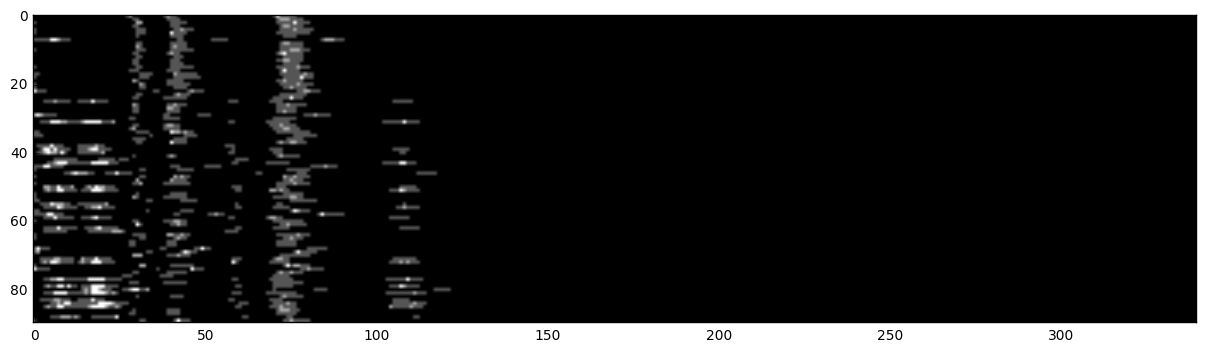

In [9]:
Image = np.load(FilePath)["Image"]
Offset = np.load(FilePath)["Offset"]
ScanConverted = np.load(FilePath)["ScanConverted"]

RawImg = np.zeros((np.shape(Image)[0],np.shape(Image)[2]))
for i in range(np.shape(Image)[0]):
    for j in range(np.shape(Image)[2]):
        RawImg[i][j] = Image[i][0][j]

plt.figure(figsize=(15, 10))
plt.imshow((RawImg[0:90,0:340]).astype(int), cmap='gray')
plt.show()

## I want to remove the delays


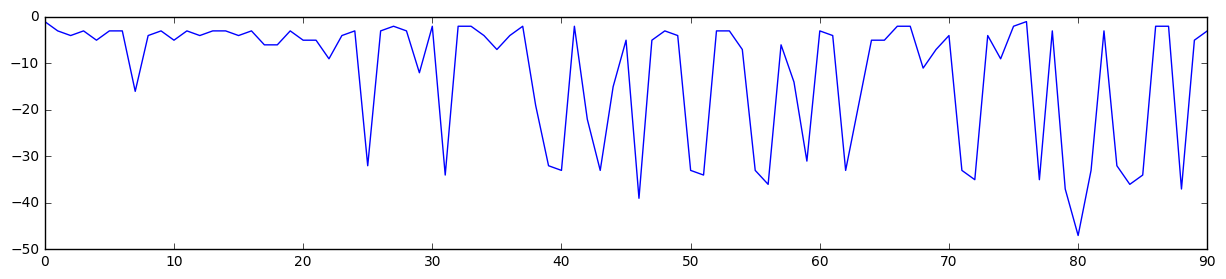

In [3]:
LineNb  =np.shape(Image)[0]
Offset = np.zeros(LineNb)
for i in range(np.shape(Image)[0]):
    Corr = signal.correlate(RawImg[0][20:350].astype(int),RawImg[i][20:350].astype(int))
    Offset[i] =  np.argmax(Corr[0:330])-330
    #print(Offset[i])
Offset = Offset.astype(int)
plt.figure(figsize=(15, 3))
plt.plot(Offset)
plt.show() 

In [4]:
OffsetImg = np.zeros((np.shape(Image)[0],np.shape(Image)[2]))
for i in range(np.shape(Image)[0]):
    for j in range(np.shape(Image)[2]-300):
        OffsetImg[i][j] = RawImg[i][j-Offset[i]]

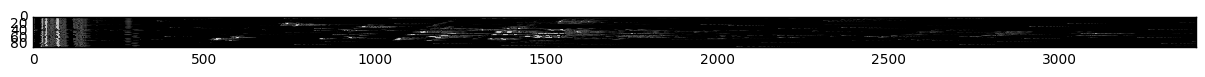

In [5]:
plt.figure(figsize=(15, 10))
plt.imshow(np.sqrt(OffsetImg[0:90,0:3400]), cmap='gray')
plt.show()

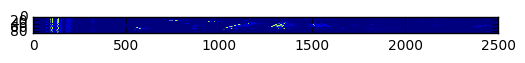

In [6]:
Img = np.zeros((91,2500))
OffSetPulser = 70  # offset of 7us
for LineNb in range(np.shape(Img)[0]):
    for PointPos in range(np.shape(Img)[1]-OffSetPulser):
        Index = find_nearest(Image[LineNb][1], PointPos/10.0)[1]
        Img[LineNb][OffSetPulser+PointPos] += OffsetImg[LineNb][Index]
plt.imshow(Img)
plt.show()

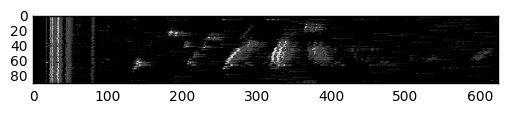

In [7]:
DECIMATION = 4
ImgDec = np.zeros((91,2500/DECIMATION))
for LineNb in range(np.shape(ImgDec)[0]):
    for PointPos in range(np.shape(ImgDec)[1]):
        for i in range(DECIMATION):
            ImgDec[LineNb][PointPos] += Img[LineNb][DECIMATION*PointPos+i]
plt.imshow(np.sqrt(ImgDec), cmap='gray')
plt.show()

625 293
(625, 586)
0%
4%
9%
14%
19%
24%
29%
34%
39%
44%
49%
54%
59%
64%
69%
74%
79%
84%
89%
94%
99%


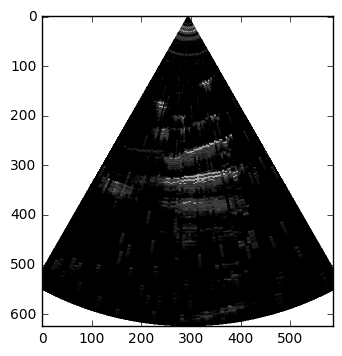

In [152]:
PointsPerLine = 2500/DECIMATION
NbOfLines = 91
maxAngle = 70.0 # Taken between 3.5 and 7
# Images
step = 1.0*maxAngle/(NbOfLines)
size = (NbOfLines,PointsPerLine)
# Depths

MaxDepth = int(PointsPerLine*math.cos(math.radians(maxAngle/2.0)))
MaxWidth = int(MaxDepth*math.sin(math.radians(maxAngle/2.0)))

X=np.zeros(shape=(size[0],size[1]))
Y=np.zeros(shape=(size[0],size[1]))

for i in range(size[0]):
    for j in range(size[1]):
        X[i][j] = j*math.cos(math.radians(step*i-maxAngle/2)) 
        Y[i][j] = MaxWidth+j*math.sin(math.radians(step*(i)-maxAngle/2)) # same

sizeSC = (size[1],2*MaxWidth)

ScanConverted=np.zeros(shape=(size[1],2*MaxWidth))
ScanConverted = ScanConverted + 4


SINAngle = math.sin(math.radians(maxAngle/2.0))

for i in range(size[1]):
    if (i<MaxDepth):
            sweep = int(i*SINAngle)+1
            for j in range((MaxWidth - sweep),(MaxWidth + sweep)):
                D = (X-i)**2 + (Y-j)**2
                resul = np.unravel_index(D.argmin(), D.shape)
                ScanConverted[i][j] = np.sqrt(ImgDec[resul[0]][resul[1]])
    
    else:
        for j in range(MaxWidth*2):
            if ( (i**2) + (j-(MaxWidth))**2 ) < ((PointsPerLine)**2 ):
                D = (X-i)**2 + (Y-j)**2
                resul = np.unravel_index(D.argmin(), D.shape)
                ScanConverted[i][j] = ImgDec[resul[0]][resul[1]]
                
plt.imshow((ScanConverted), cmap='gray')
plt.show()

In [156]:
np.savez_compressed(FilePath,Image=Image,Offset=Offset,ScanConverted=ScanConverted)

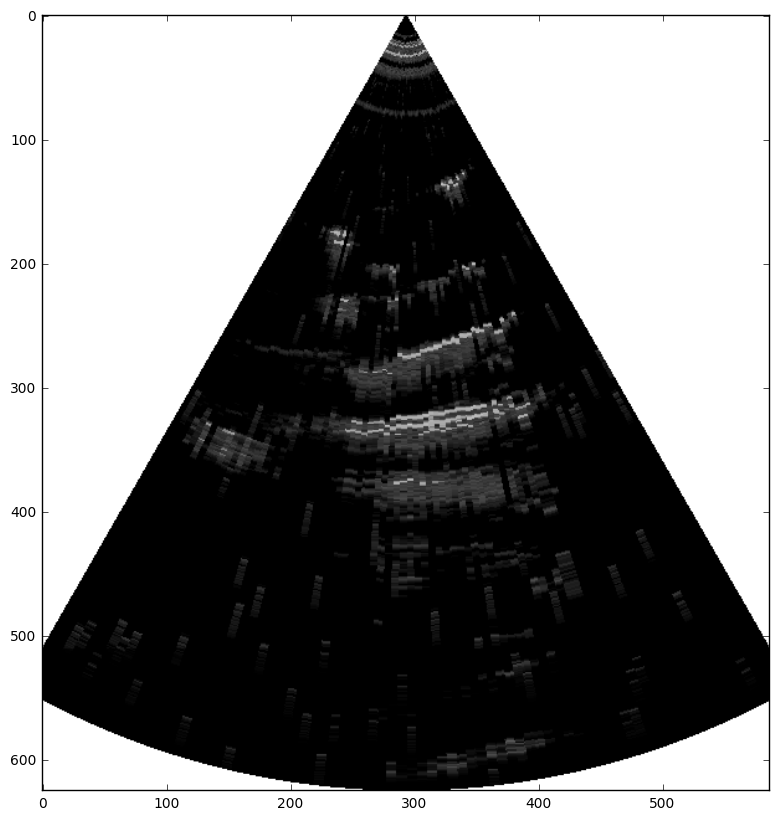

In [8]:
plt.figure(figsize=(15, 10))
plt.imshow((ScanConverted), cmap='gray')
plt.show()

# Conclusion

* The pulser works.. but some delays don't work
* ADC seems to work nicely
* Crappy stuff is the servo..